In [53]:
import astropy.io.fits as pyfits

import os
import pickle
import numpy as np
import pandas as pd

from skimage.transform import rescale, rotate
from skimage.util import crop

import matplotlib.pyplot as plt
%matplotlib inline

### Read label file

In [2]:
label_file = "R_filtrid/BD_decomp_asi.txt"
threshold = 1.5
galaxies_info = pd.read_table(label_file, sep='\t', lineterminator='\n',skiprows=1,header=None,index_col=False,
                              names=["cnr","n","kval","varb","dust","popul","rescale"],
                             usecols=["cnr","kval","varb","dust","popul","rescale"])
#galaxies_info['LABEL'] =  np.array(galaxies_info['kval']>threshold).astype(int)
galaxies_info.head()

,cnr,kval,varb,dust,popul,rescale
0,105,2.0,0,T,T,F
1,106,1.0,1,F,F,F
2,107,2.0,0.2,F,T,F
3,108,1.5,0,F,T,F
4,113,2.0,0,F,T,F


### Read fits files, log transform

In [3]:
galaxies_fits = []
path = "R_filtrid/"
a=1000
log_transform = True
for num in galaxies_info['cnr']:
    fits_file = pyfits.getdata(path+str(num)+".fits")
    if log_transform:
        fits_file = np.log(a*(fits_file-fits_file.min())/(fits_file.max()-fits_file.min())+1)/np.log(a)
    galaxies_fits.append(fits_file)

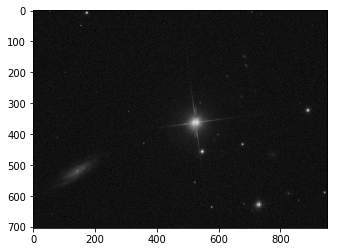

In [4]:
plt.imshow(galaxies_fits[7], cmap='gray')

### Get circles

In [7]:
# load previously saved results without recalculation
galaxy_circles = pickle.load( open( "galaxy_circles_v1.p", "rb" ) )

159.0 96.0


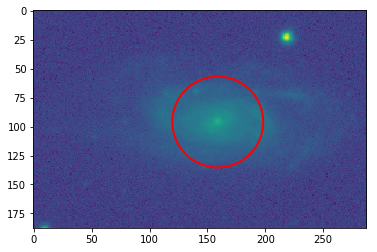

In [12]:
i=24
fig, ax = plt.subplots()
ax.imshow(galaxies_fits[i])
y,x,r = galaxy_circles[i]
print(x,y)
circle = plt.Circle((x, y), r, color = 'red', linewidth=2, fill=False)
ax.add_patch(circle)

### Augmentation

1.31538461538
(145, 514)
45 414
(100, 100)
(100, 100)


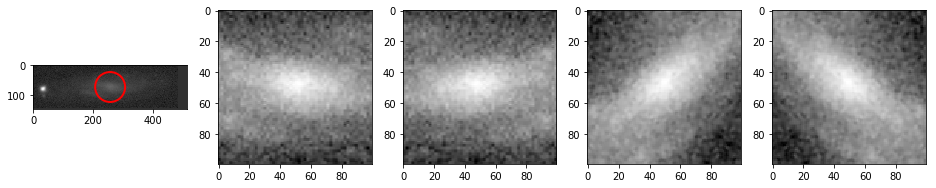

In [74]:
# experiment for one image
img_size = 100

i=25
img = galaxies_fits[i]
y,x,r = galaxy_circles[i]

r_mult = min(np.sqrt(np.min(img.shape)**2/8)/r,4)
print(r_mult)

# move galaxy to the center
add_left = int(max(0, (img.shape[1]-2*x)))
add_right = int(max(0, -(img.shape[1]-2*x)))
add_up = int(max(0, (img.shape[0]-2*y)))
add_down = int(max(0, -(img.shape[0]-2*y)))
x = x+add_left
y = y+add_up
imgP = np.pad(img, ((add_up, add_down),(add_left, add_right)), 'constant',constant_values = np.mean(img))

# Scale so that galaxy will take 100pix
imgN = (imgP-np.min(imgP))/(np.max(imgP)-np.min(imgP))
scale = img_size/(2*r_mult*r)
#print(scale)
rescaled_image = rescale(imgN, scale,mode='constant') #, anti_aliasing=True)
x = x*scale
y = y*scale
r = r*scale
print(rescaled_image.shape)

crop_x = rescaled_image.shape[0]-img_size
crop_y = rescaled_image.shape[1]-img_size
print(crop_x,crop_y)
img_cropped = crop(rescaled_image, ((np.ceil(crop_x/2),crop_x-np.ceil(crop_x/2)),(np.ceil(crop_y/2),crop_y-np.ceil(crop_y/2))))
print(img_cropped.shape)

img_flipped = np.fliplr(img_cropped)

img_rotated = rotate(rescaled_image,45,preserve_range=True)
crop_rotated_x = img_rotated.shape[0]-img_size
crop_rotated_y = img_rotated.shape[1]-img_size
img_rotated_cropped = crop(img_rotated, ((np.ceil(crop_rotated_x/2),crop_rotated_x-np.ceil(crop_rotated_x/2)),
                                         (np.ceil(crop_rotated_y/2),crop_rotated_y-np.ceil(crop_rotated_y/2))))
print(img_rotated_cropped.shape)
img_rotated_flipped = np.fliplr(img_rotated_cropped)

fig, ax = plt.subplots(1,5,figsize = (16,4))

ax[0].imshow(rescaled_image,cmap='gray')
circle = plt.Circle((x, y), r_mult*r, color = 'red', linewidth=2, fill=False)
ax[0].add_patch(circle)

ax[1].imshow(img_cropped,cmap='gray')
ax[2].imshow(img_flipped,cmap='gray')
ax[3].imshow(img_rotated_cropped,cmap='gray')
ax[4].imshow(img_rotated_flipped,cmap='gray')
plt.show()

### Run for all

In [75]:
# run for all
img_size = 100
cropped_galaxies = []

for i in range(len(galaxies_fits)):    
    img = galaxies_fits[i]
    y,x,r = galaxy_circles[i]

    r_mult = min(np.sqrt(np.min(img.shape)**2/8)/r,4)
    #print(r_mult)

    # move galaxy to the center
    add_left = int(max(0, (img.shape[1]-2*x)))
    add_right = int(max(0, -(img.shape[1]-2*x)))
    add_up = int(max(0, (img.shape[0]-2*y)))
    add_down = int(max(0, -(img.shape[0]-2*y)))
    x = x+add_left
    y = y+add_up
    imgP = np.pad(img, ((add_up, add_down),(add_left, add_right)), 'constant',constant_values = np.mean(img))

    # Scale so that galaxy will take 100pix
    imgN = (imgP-np.min(imgP))/(np.max(imgP)-np.min(imgP))
    scale = img_size/(2*r_mult*r)
    #print(scale)
    rescaled_image = rescale(imgN, scale,mode='constant') #, anti_aliasing=True)
    x = x*scale
    y = y*scale
    r = r*scale
    #print(rescaled_image.shape)
    
    # Crop image
    crop_x = rescaled_image.shape[0]-img_size
    crop_y = rescaled_image.shape[1]-img_size
    #print(crop_x,crop_y)
    img_cropped = crop(rescaled_image, ((np.ceil(crop_x/2),crop_x-np.ceil(crop_x/2)),
                                        (np.ceil(crop_y/2),crop_y-np.ceil(crop_y/2))))
    #print(img_cropped.shape)
    
    # Flip image
    img_flipped = np.fliplr(img_cropped)

    # Rotate image
    img_rotated = rotate(rescaled_image,45,preserve_range=True)
    crop_rotated_x = img_rotated.shape[0]-img_size
    crop_rotated_y = img_rotated.shape[1]-img_size
    img_rotated_cropped = crop(img_rotated, ((np.ceil(crop_rotated_x/2),crop_rotated_x-np.ceil(crop_rotated_x/2)),
                                             (np.ceil(crop_rotated_y/2),crop_rotated_y-np.ceil(crop_rotated_y/2))))
    #print(img_rotated_cropped.shape)
    # Flip rotated image
    img_rotated_flipped = np.fliplr(img_rotated_cropped)
    if sum([img_cropped.shape[0],img_cropped.shape[1],img_flipped.shape[0],img_flipped.shape[1],
            img_rotated_cropped.shape[0],img_rotated_cropped.shape[1],
            img_rotated_flipped.shape[0],img_rotated_flipped.shape[1]])!=img_size*8:
        print(i)
        
    cropped_galaxies.append([img_cropped,img_flipped,img_rotated_cropped,img_rotated_flipped])

# save results
pickle.dump(cropped_galaxies, open( "cropped_galaxies_v2.p", "wb" ) )

In [4]:
cropped_galaxies = pickle.load( open( "cropped_galaxies_v2.p", "rb" ) )

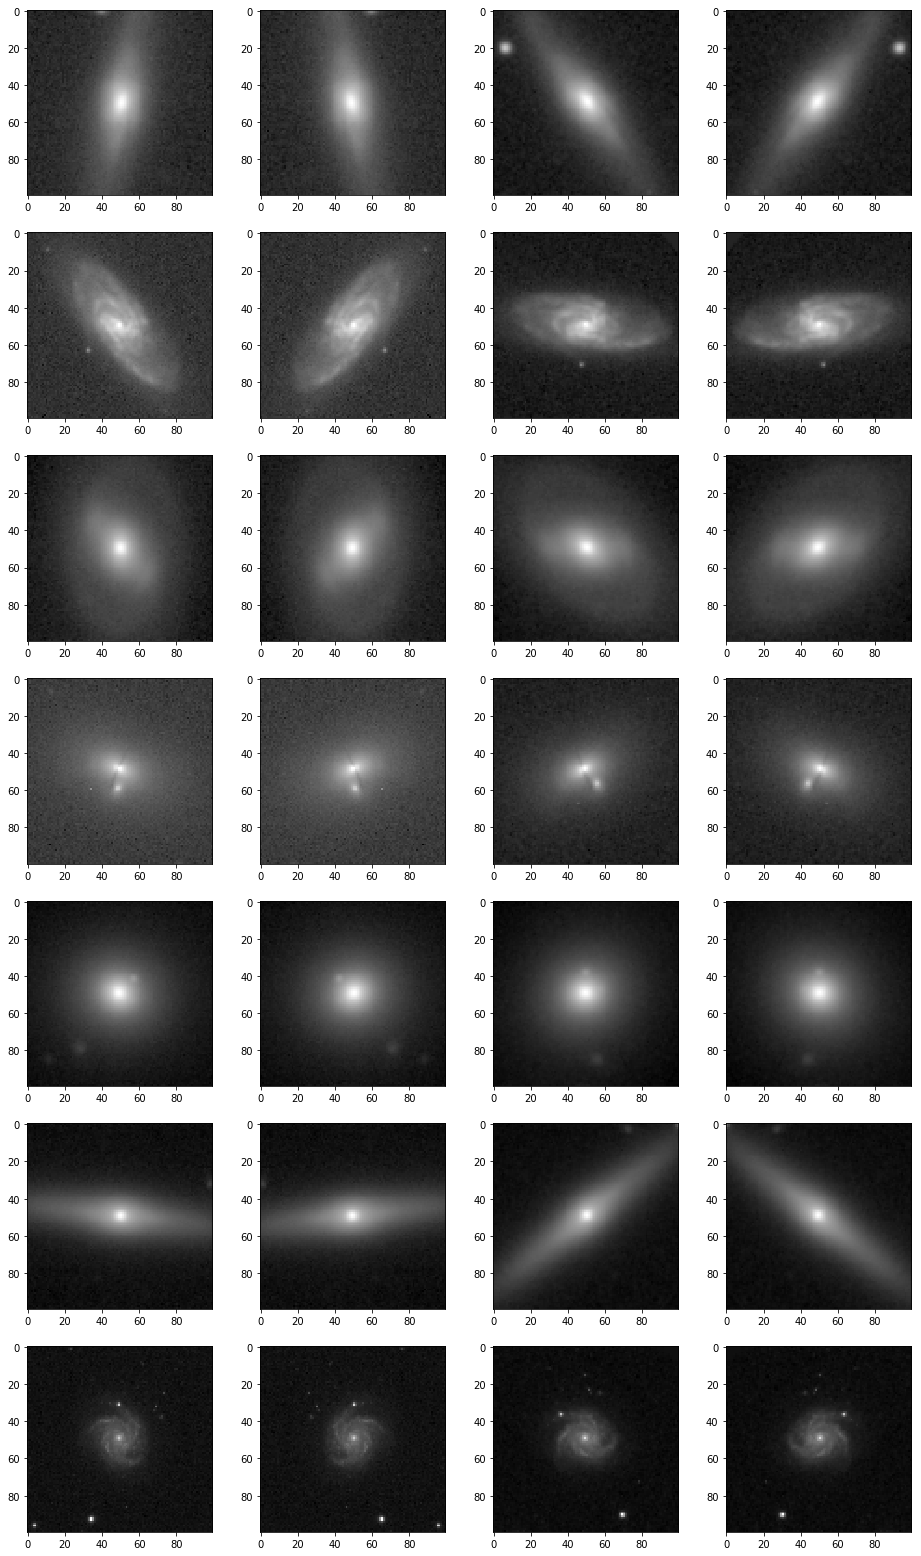

In [78]:
subset = 0
counts = 7
fig, ax = plt.subplots(counts,4,figsize = (16,4*counts))
for i in range(counts): 
    im1,im2,im3,im4 = cropped_galaxies[i]
    ax[i][0].imshow(im1,cmap='gray')
    ax[i][1].imshow(im2,cmap='gray')
    ax[i][2].imshow(im3,cmap='gray')
    ax[i][3].imshow(im4,cmap='gray')
plt.show()